# Plot the whole pipeline

This script is used for plotting figures showing the whole pipeline

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json
import pandas as pd

PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'Repos'

sys.path.append(str(USER_ROOT / 'patientflow' / 'src' / 'patientflow'))
sys.path.append(str(USER_ROOT / 'patientflow' / 'functions'))

model_file_path = USER_ROOT / 'patientflow' / 'trained-models'
model_file_path.mkdir(parents=True, exist_ok=True)
data_path = USER_ROOT / 'patientflow' / 'data-raw'
media_file_path = USER_ROOT / 'patientflow' / 'notebooks' / 'img'
media_file_path.mkdir(parents=True, exist_ok=True)


## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [3]:
uclh = False

In [4]:
from load_config import load_config_file

if uclh:
    config_path = Path(USER_ROOT / 'patientflow' / 'config-uclh.yaml')
else:
    config_path = Path(USER_ROOT / 'patientflow' / 'config.yaml')

params = load_config_file(config_path)

prediction_times = params[0]
start_training_set, start_validation_set, start_test_set, end_test_set = params[1:5]
x1, y1, x2, y2 = params[5:9]
prediction_window = params[10]

# Load data and select snapshot to plot

In [6]:
pd.read_csv(visits_csv_path)

,snapshot_id,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,...,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,training_validation_test,final_sequence,is_admitted,random_number,specialty
0,0,2030-04-09,"(12, 0)",1.0,780.0,F,45-54,Walk-in,waiting,2.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,121958,surgical
1,1,2030-04-09,"(15, 30)",1.0,13380.0,F,45-54,Walk-in,majors,5.0,...,0.5,141.0,6.84,7.371,5.28,train,[],False,146867,surgical
2,2,2030-08-03,"(12, 0)",3.0,4620.0,M,65-74,Walk-in,waiting,2.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,131932,medical
3,3,2030-11-01,"(22, 0)",4.0,15600.0,F,75-102,NaN,sdec,4.0,...,1.2,136.0,5.41,7.371,14.10,train,['acute'],True,103694,surgical
4,4,2030-04-24,"(12, 0)",5.0,4500.0,F,35-44,Walk-in,sdec_waiting,4.0,...,NaN,NaN,NaN,NaN,NaN,train,['ambulatory'],False,119879,surgical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198093,198093,2030-12-07,"(6, 0)",196140.0,7569.0,M,18-24,Ambulance,majors,3.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,151483,NaN
198094,198094,2030-05-22,"(6, 0)",196141.0,9541.0,M,0-17,Walk-in,paeds,2.0,...,NaN,NaN,NaN,NaN,NaN,train,['paeds'],False,168174,NaN
198095,198095,2030-05-22,"(6, 0)",196142.0,9445.0,F,0-17,Walk-in,paeds,2.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,110567,NaN
198096,198096,2030-12-07,"(6, 0)",196143.0,8054.0,M,0-17,Ambulance,paeds,2.0,...,NaN,NaN,NaN,NaN,NaN,train,['surgical'],True,124907,NaN


In [8]:
import pandas as pd
from load_data_utils import set_file_locations

if uclh:
    visits_path, visits_csv_path, yta_path, yta_csv_path = set_file_locations(uclh, data_path, config_path)
else:
    visits_csv_path, yta_csv_path = set_file_locations(uclh, data_path)

from load import data_from_csv
visits = data_from_csv(visits_csv_path, index_column = 'snapshot_id',
                            sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                            eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])
yta = pd.read_csv(yta_csv_path)

visits['snapshot_date'] = pd.to_datetime(visits['snapshot_date']).dt.date



In [20]:
prediction_time_ = prediction_times[3]
for r in range(0,10):
    random_snapshot_date = visits.loc[visits.training_validation_test == 'test', 'snapshot_date'].sample(n=1, random_state=r).iloc[0]
    print(len(visits[(visits.snapshot_date == random_snapshot_date) & (visits.prediction_time == prediction_time_) & (visits.current_location_type != 'OTF')]))

114
86
89
119
68
24
40
117
68
70


In [31]:
# pick a random snapshot_date and time of day in the test set
prediction_time_ = prediction_times[3]
random_snapshot_date = visits.loc[visits.training_validation_test == 'test', 'snapshot_date'].sample(n=1, random_state=0).iloc[0]

hour_, min_ = prediction_time_
min_ = f"{min_}0" if min_ % 60 == 0 else str(min_)
snapshot_datetime = random_snapshot_date + '_'+ str(hour_) + '-' + str(min_ )

# create folder to save the plots in
full_file_path = media_file_path / 'pipeline_figures' /snapshot_datetime / 'full'
pipeline_file_path = media_file_path / 'pipeline_figures' /snapshot_datetime / 'minimal'
os.makedirs(pipeline_file_path, exist_ok=True)
os.makedirs(full_file_path, exist_ok=True)

# get the data for this random time
ex = visits[(visits.snapshot_date == random_snapshot_date) & (visits.prediction_time == prediction_time_) & (visits.current_location_type != 'OTF')].copy()
print(len(ex))

truncate_at_ = 40 if len(ex) > 100 else 20


# reduce number of locations for presentation purposes
mapping = {'utc': 'Minors', 
           'majors': 'Majors/Resus', 
           'sdec': 'Other', 
           'paeds': 'Other', 
           'waiting': 'Other', 
           'rat': 'Majors/Resus', 
           'sdec_waiting': 'Other', 
           'resus' : 'Majors/Resus',
            'taf' : 'Other'}

categories = ['Majors/Resus', 'Minors', 'Other']  # Define order

ex['loc_new'] = ex['current_location_type'].map(mapping)
ex['loc_new'] = pd.Categorical(ex['loc_new'], categories=categories, ordered=True)


114


## Set up plot

In [23]:
# set plot parameters
figsize_global = tuple([6,3])
full_output = False

from plot_pipeline import create_colour_dict
spec_colour_dict = create_colour_dict()

## Figure a

In [24]:
ex.current_location_type.value_counts()

current_location_type
majors          28
utc             25
rat             18
sdec            14
waiting         13
sdec_waiting     7
paeds            7
taf              1
resus            1
Name: count, dtype: int64

/home/jovyan/work/patientflow/functions/plot_pipeline.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for location, group in ex.groupby('loc_new'):


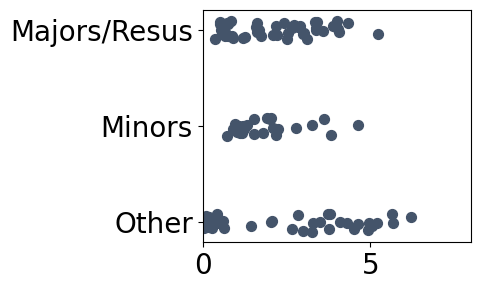

In [25]:
from plot_pipeline import in_ED_now_plot

title_ = f'Patients in ED at {snapshot_datetime}' 
if full_output:    
    in_ED_now_plot(full_file_path, 'Full Figure a', ex, snapshot_datetime, figsize_global, title_, include_titles = True, size = 20)
else:
    in_ED_now_plot(pipeline_file_path, 'Figure a', ex, snapshot_datetime, figsize_global, title_, text_size= 20)

## Figure b

/home/jovyan/work/patientflow/functions/plot_pipeline.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for location, group in ex.groupby('loc_new'):


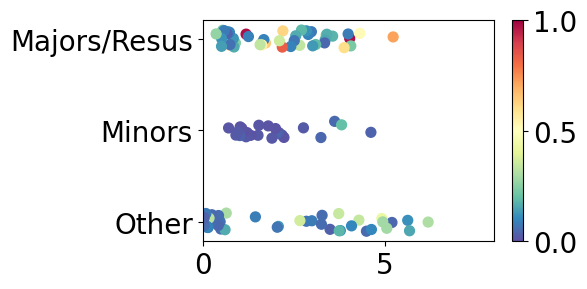

In [26]:
from ed_admissions_helper_functions import prepare_for_inference
from predict.emergency_demand.from_individual_probs import model_input_to_pred_proba

# load saved model
model = prepare_for_inference(model_file_path = model_file_path, model_name = 'ed_admission', prediction_time = prediction_time_, data_path = None, single_snapshot_per_visit = False, model_only = True)

# get probabilities
episode_slices_in_ex = ex.index[(ex.snapshot_date == random_snapshot_date)]
preds = model_input_to_pred_proba(ex, model)
ex['preds'] = preds['pred_proba'].values

title = f'Patients in ED at {snapshot_datetime}' 
if full_output:
    in_ED_now_plot(full_file_path, 'Full Figure b', ex, snapshot_datetime, figsize_global, title_, include_titles = True, size = 20, colour = True, colour_map = 'Spectral_r')# spec_colour_dict['spectrum']['all'])
else:
    in_ED_now_plot(pipeline_file_path, 'Figure b', ex, snapshot_datetime, figsize_global, title_, text_size= 20, colour = True, colour_map = 'Spectral_r')


## Figure c

In [27]:
import datetime
visits['snapshot_date'] = pd.to_datetime(visits['snapshot_date']).dt.date
visits['snapshot_datetime'] = visits.apply(lambda row: datetime.datetime.combine(
    row['snapshot_date'], 
    datetime.time(row['prediction_time'][0], row['prediction_time'][1])
).replace(tzinfo=datetime.timezone.utc), axis=1)

Calculating probability distributions for 1 horizon dates
Processed 1 horizon dates


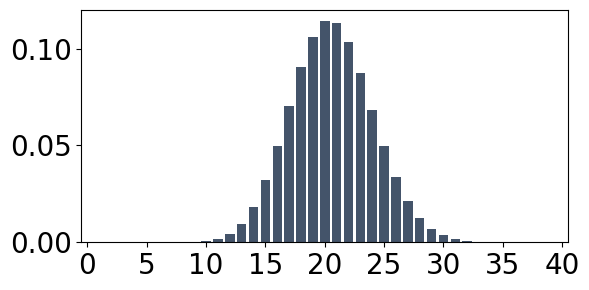

In [32]:
from load import data_from_csv
visits = data_from_csv(visits_csv_path, 
                            sort_columns = ["visit_number", "snapshot_datetime"], 
                            eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])
from predict.emergency_demand.from_individual_probs import get_prob_dist
from viz.prob_dist_plot import prob_dist_plot

from ed_admissions_helper_functions import prepare_for_inference


from ed_admissions_helper_functions import prepare_snapshots_dict


# prepare data 
X_test, y_test, model = prepare_for_inference(model_file_path, 'ed_admission', prediction_time = prediction_time_, data_path = visits_csv_path, single_snapshot_per_visit = False)


episode_slices_dict = prepare_snapshots_dict(visits[(visits.training_validation_test == 'test') & (visits.prediction_time == prediction_time_) & (visits.snapshot_date == random_snapshot_date)])
prob_dist = get_prob_dist(
    episode_slices_dict, X_test, y_test, model
)

    
    

if full_output:

    title_ = f'Probability distribution for number of beds needed\n for patients in ED at {random_snapshot_date} {hour_}-{min_}'
    prob_dist_plot(prob_dist_data=prob_dist[random_snapshot_date]['pred_demand'], title_=title_, directory_path=full_file_path, figsize=figsize_global, include_titles=True, 
                   file_name = 'Full Figure c', truncate_at_beds = truncate_at_,
                  bar_colour = spec_colour_dict['single']['all'])
else:
    title_ = 'Figure c'
    prob_dist_plot(prob_dist_data=prob_dist[random_snapshot_date]['pred_demand'], title_=title_, directory_path=pipeline_file_path, figsize=figsize_global, text_size=20, 
                   file_name = 'Figure c', truncate_at_beds = truncate_at_,
                  bar_colour = spec_colour_dict['single']['all'])


In [33]:
prob_dist[random_snapshot_date]['pred_demand']

,agg_proba
0,1.95279063776518e-14
1,2.18121331189241e-12
2,9.27298447500833e-11
3,2.01689528593282e-9
4,2.74725019328216e-8
...,...
110,9.44831918876937e-105
111,1.77499933543039e-107
112,2.43545220218967e-110
113,2.16939497642622e-113


### Figure d - currently done in powerpoint

In [ ]:
specialty_model = prepare_for_inference(model_file_path, 'ed_specialty', model_only=True)

weights = specialty_model.weights
weights[tuple(['surgical'])]

In [ ]:
# visits_admitted_with_spec = visits[(visits.is_admitted)].merge(visits_spec[['episode_slice_id','consultation_sequence', 'observed_specialty']] , on='episode_slice_id', how='left')
# visits_admitted_with_spec.loc[visits_admitted_with_spec.consultation_sequence.isnull(), 'consultation_sequence'] = 'None'

# spec_dict = {}
# spec_dict['-'] = spec_dict = {'-': {k[0].upper(): v for k, v in visits_admitted_with_spec[visits_admitted_with_spec.consultation_sequence == 'None']['observed_specialty'].value_counts(normalize=True).to_dict().items()}}


# spec_dict['-']['-m'] = {k[0].upper(): v for k, v in visits_admitted_with_spec[visits_admitted_with_spec.consultation_sequence == "('medical',)"]['observed_specialty'].value_counts(normalize=True).to_dict().items()}
# spec_dict['-']['-s'] = {k[0].upper(): v for k, v in visits_admitted_with_spec[visits_admitted_with_spec.consultation_sequence == "('surgical',)"]['observed_specialty'].value_counts(normalize=True).to_dict().items()}
# spec_dict['-']['-h'] = {k[0].upper(): v for k, v in visits_admitted_with_spec[visits_admitted_with_spec.consultation_sequence == "('haem/onc',)"]['observed_specialty'].value_counts(normalize=True).to_dict().items()}
# spec_dict#['-']['-m'].keys()


### Figure e - NOTE currently there is no data on consults for discharged patients

Possible fixes - save consults data with original visits. 

In [32]:
ex[(ex.has_consultation) & (ex.is_admitted)].index

visits_spec[ex[(ex.has_consultation) & (ex.is_admitted)].index]

KeyError: "None of [Index([234260, 234283, 234316], dtype='int64', name='snapshot_id')] are in the [columns]"

In [59]:
spec

,age_group,consultation_sequence,specialty
snapshot_id,,,
233440,25-34,(),NaN
233580,65-74,(),NaN
233975,45-54,(),NaN
233988,25-34,(),NaN
234004,75-102,(),NaN
...,...,...,...
234388,35-44,(),NaN
234389,25-34,(),NaN
234390,35-44,(),NaN


/home/jovyan/work/patientflow/functions/plot_pipeline.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for location, group in ex.groupby('loc_new'):


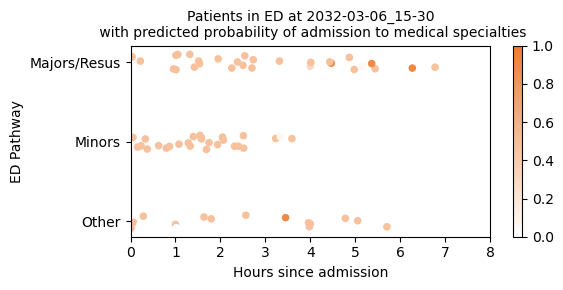

/home/jovyan/work/patientflow/functions/plot_pipeline.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for location, group in ex.groupby('loc_new'):


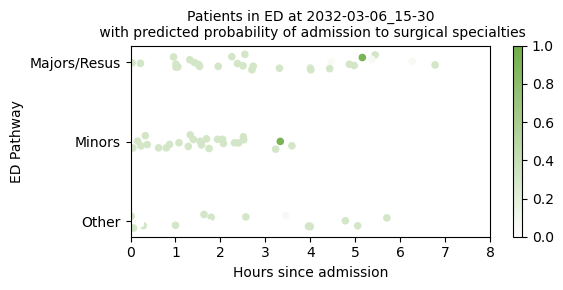

/home/jovyan/work/patientflow/functions/plot_pipeline.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for location, group in ex.groupby('loc_new'):


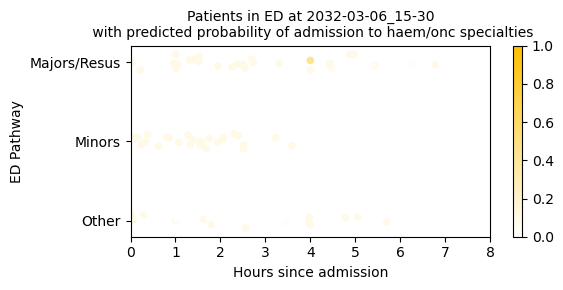

/home/jovyan/work/patientflow/functions/plot_pipeline.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for location, group in ex.groupby('loc_new'):


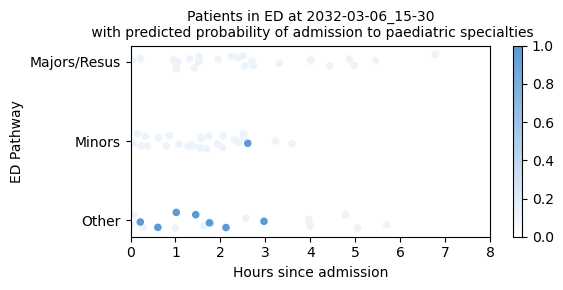

In [220]:
from ed_admissions_helper_functions import get_specialty_probs, prepare_snapshots_dict


# Define a function to handle the conversion to tuple
def convert_to_tuple(x):
    if isinstance(x, float) and pd.isna(x):
        return ()
    elif isinstance(x, tuple):
        return x
    elif isinstance(x, list):
        return tuple(x)
    else:
        # Handle other types if necessary, or raise an error
        raise ValueError(f"Unexpected type: {type(x)}")


child_age_group = '0-17'
child_dict = {
    'medical': 0.0,
    'surgical': 0.0,
    'haem/onc': 0.0,
    'paediatric': 1.0
}

X_test, y_test, model = prepare_for_inference(model_file_path, 'ed_admission', prediction_time = prediction_time_, data_path = visits_csv_path, single_snapshot_per_visit = False)
episode_slices_dict = prepare_snapshots_dict(visits[(visits.training_validation_test == 'test') & (visits.prediction_time == prediction_time_) & (visits.snapshot_date == random_snapshot_date)])

is_child_func = lambda row: row['age_group'] == '0-17' # or row['age'] <= 17


spec = pd.merge(ex[['age_group']], visits_spec[['consultation_sequence', 'specialty']], left_index=True, right_index=True, how='left')
# after merge, set NA values to empty tuple

spec['consultation_sequence'] = spec['consultation_sequence'].apply(convert_to_tuple)


spec['specialty_prob'] = get_specialty_probs(model_file_path, spec, special_category_func=is_child_func, special_category_dict=child_dict)

specs =  ['medical', 'surgical', 'haem/onc', 'paediatric']
spec = spec.assign(**{f'{key}_prob': spec['specialty_prob'].apply(lambda d: d.get(key)) for key in specs})

# spec = pd.merge(ex['prob_admission_in_window'], spec, left_index=True, right_index=True, how='left')
ex_spec = pd.merge(ex, spec, left_index=True, right_index=True, how='left')

for spec_ in ['medical', 'surgical', 'haem/onc', 'paediatric']:

    if full_output:    
        title_ = f'Patients in ED at {snapshot_datetime}\n' 
        in_ED_now_plot(full_file_path, f'Full Figure e {spec_.replace("/", "_")}', ex_spec, snapshot_datetime, figsize_global, title_, include_titles = True, colour = True, colour_map = spec_colour_dict['spectrum'][spec_], 
                       size = 20, preds_col = f'{spec_}_prob', title_suffix = f'admission to {spec_} specialties')
    else:
        title_ = 'Figure e' 
        in_ED_now_plot(pipeline_file_path, f'Figure e {spec_.replace("/", "_")}', ex_spec, snapshot_datetime, figsize_global, title_, text_size= 20, colour = True, colour_map = spec_colour_dict['spectrum'][spec_], preds_col = f'{spec_}_prob')

## Figure f

'haem_onc'


Processing probability of admission to:medical
Calculating probability distributions for 1 horizon dates
Processed 1 horizon dates

Processing probability of admission to:surgical
Calculating probability distributions for 1 horizon dates
Processed 1 horizon dates

Processing probability of admission to:haem/onc
Calculating probability distributions for 1 horizon dates
Processed 1 horizon dates

Processing probability of admission to:paediatric
Calculating probability distributions for 1 horizon dates
Processed 1 horizon dates


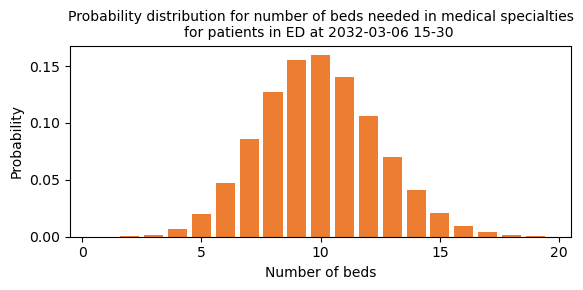

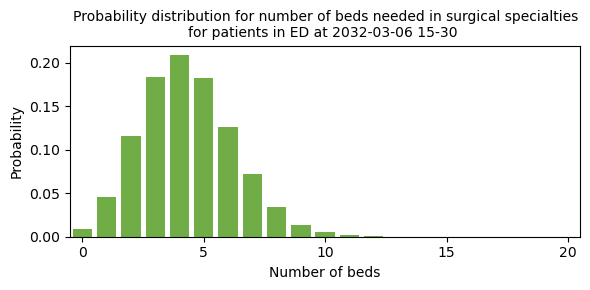

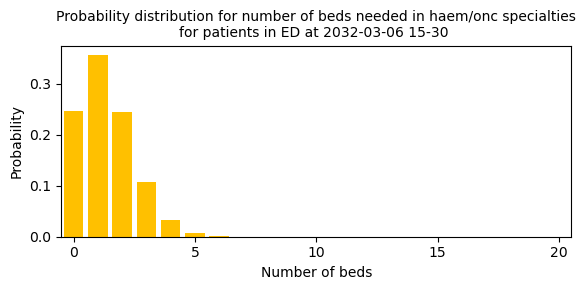

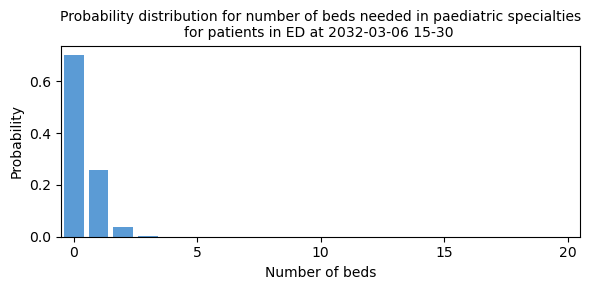

In [183]:
prob_dist_spec = {}
spec_colour_dict = create_colour_dict()

for spec_ in ['medical', 'surgical', 'haem/onc', 'paediatric']:
    print("\nProcessing probability of admission to:" + spec_ )

    # get the probability of admission to this specialty for all patients
    weights = spec['specialty_prob'].apply(lambda x: x.get(spec_))

    # select only the episode slices that pertain to children or adults, as appropriate
    if spec_ == 'paediatric':
        episode_slices_dict = prepare_snapshots_dict(ex_spec[ex_spec.age_group_x == '0-17'])
    else:
        episode_slices_dict = prepare_snapshots_dict(ex_spec[ex_spec.age_group_x != '0-17'])
        
    # get probability distribution for this time of day
    prob_dist_spec[spec_] = get_prob_dist(
        episode_slices_dict, X_test, y_test, model, weights
    )

for spec_ in ['medical', 'surgical', 'haem/onc', 'paediatric']:

    if full_output:

        title_ = f'Probability distribution for number of beds needed in {spec_} specialties\nfor patients in ED at {random_snapshot_date} {hour_}-{min_} '
        prob_dist_plot(prob_dist_data=prob_dist_spec[spec_][random_snapshot_date]['pred_demand'], title_=title_, directory_path=full_file_path, figsize=figsize_global, include_titles=True, 
                       bar_colour= spec_colour_dict['single'][spec_], file_name = f'Full Figure f {spec_.replace("/", "_")}')
    else:
        title_ = 'Figure f'
        prob_dist_plot(prob_dist_data=prob_dist_spec[spec_][random_snapshot_date]['pred_demand'], title_=title_, directory_path=pipeline_file_path, figsize=figsize_global, text_size=20, 
                       bar_colour= spec_colour_dict['single'][spec_], file_name = f'Figure f {spec_.replace("/", "_")}')

## Figure g 

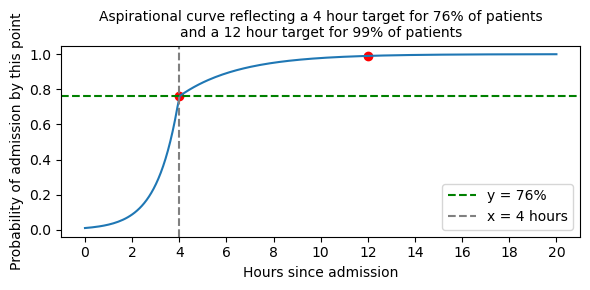

In [222]:

from predict.emergency_demand.admission_in_prediction_window_using_aspirational_curve import calculate_probability
from viz.aspirational_curve_plot import plot_curve

prediction_window_hrs = prediction_window/60
ex_spec['elapsed_los_hrs'] = ex_spec['elapsed_los']/3600

ex_spec['prob_adm_in_window'] = ex_spec.apply(lambda row: calculate_probability(row['elapsed_los_hrs'], prediction_window_hrs, x1 = 4, y1 = 0.76, x2 = 12, y2 = .99), axis=1)


directory_path = media_file_path / snapshot_datetime

if full_output:

    title_ = 'Aspirational curve reflecting a ' + str(int(x1)) + ' hour target for ' + str(int(y1*100)) + \
        '% of patients\nand a '+ str(int(x2)) + ' hour target for ' + str(int(y2*100)) + '% of patients'
    plot_curve(figsize = figsize_global, title = title_, x1 = 4, y1 = .76, x2 = 12, y2 = 0.99, include_titles = True, file_name = 'Full Figure g', directory_path = pipeline_file_path)
    
else:
    
    title_ = 'Figure g'
    plot_curve(figsize = figsize_global, title = title_, x1 = 4, y1 = .76, x2 = 12, y2 = 0.99,  text_size = 20, file_name = 'Figure g', directory_path = pipeline_file_path)
    

## Figure h

/home/jovyan/work/patientflow/functions/plot_pipeline.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for location, group in ex.groupby('loc_new'):


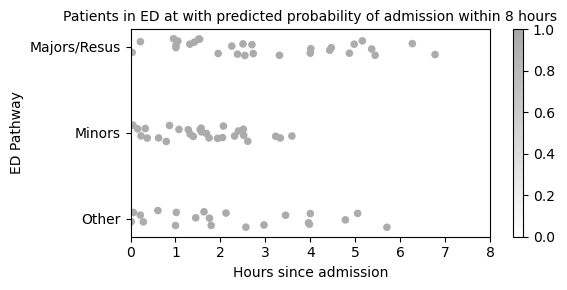

In [185]:
if full_output:    
    title_ = 'Patients in ED at' 
    in_ED_now_plot(full_file_path, 'Full figure h', ex_spec, snapshot_datetime, figsize_global, title_, include_titles = True, colour = True, colour_map = spec_colour_dict['spectrum']['window'], size = 20, preds_col = 'prob_adm_in_window', 
                   title_suffix = 'admission within ' + str(int(prediction_window_hrs)) + ' hours')
else:
    title_ = 'Figure h' 
    in_ED_now_plot(pipeline_file_path, 'Figure h', ex_spec, snapshot_datetime,  figsize_global, title_, text_size= 20, colour = True, colour_map = spec_colour_dict['spectrum']['window'], preds_col = 'prob_adm_in_window')

## Figure i


In [156]:
model

Pipeline(steps=[('feature_transformer',
                 ColumnTransformer(transformers=[('elapsed_los_td',
                                                  'passthrough',
                                                  ['elapsed_los_td']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex']),
                                                 ('arrival_method',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['arrival_method']),
                                                 ('current_location_type',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['current_location_type']),
                                                 ('to...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=30, n_jobs=-1,
                               num_parallel_tree=None, random_state=None, ...))])

In [34]:
from ed_admissions_realtime_preds import index_of_sum
from viz.prob_dist_plot import prob_dist_plot
cvisits_cut_points = [0.9, 0.7]


prob_dist_spec_in_window = {}

for spec_ in ['medical', 'surgical', 'haem/onc', 'paediatric']:
    print("\nProcessing probability of admission to:" + spec_ )

    # get the probability of admission to this specialty for all patients
    weights = ex_spec['specialty_prob'].apply(lambda x: x.get(spec_))
    
    # multiply by probability of admission in window
    weights_in_window = weights * ex_spec['prob_adm_in_window']

    # select only the episode slices that pertain to children or adults, as appropriate
    if spec_ == 'paediatric':
        episode_slices_dict = prepare_snapshots_dict(ex_spec[ex_spec.age_group_x == '0-17'])
    else:
        episode_slices_dict = prepare_snapshots_dict(ex_spec[ex_spec.age_group_x != '0-17'])
        
    # get probability distribution for this time of day
    prob_dist_spec_in_window[spec_] = get_prob_dist(
        episode_slices_dict, X_test, y_test, model, weights_in_window
    )


for spec_ in ['medical', 'surgical', 'haem/onc', 'paediatric']:

    plot_lines_at = {}

    for cut_point in cvisits_cut_points: 
        
        plot_lines_at[cut_point] = index_of_sum(prob_dist_spec_in_window[spec_][random_snapshot_date]['pred_demand']["agg_proba"].values, cut_point)

    if full_output:
        # with cvisits lines
        title_ = f'Probability distribution for beds needed in {spec_} specialties within {str(int(prediction_window_hrs))} hours\nfor patients in ED at {random_snapshot_date} {hour_}-{min_} '
        prob_dist_plot(prob_dist_data=prob_dist_spec_in_window[spec_][random_snapshot_date]['pred_demand'], title_=title_, directory_path=full_file_path, figsize=figsize_global, include_titles=True, 
                       bar_colour=spec_colour_dict['single'][spec_], file_name = f'Full Figure i {spec_.replace("/", "_")} with cvisits lines', min_beds_lines = plot_lines_at)
        # without cvisits lines
        title_ = f'Probability distribution for beds needed in {spec_} specialties within {str(int(prediction_window_hrs))} hours\nfor patients in ED at {random_snapshot_date} {hour_}-{min_} '
        prob_dist_plot(prob_dist_data=prob_dist_spec_in_window[spec_][random_snapshot_date]['pred_demand'], title_=title_, directory_path=full_file_path, figsize=figsize_global, include_titles=True, 
                       bar_colour=spec_colour_dict['single'][spec_], file_name = f'Full Figure i {spec_.replace("/", "_")}')
    else: 
        # without cvisits lines
        title_ = f'Figure i {spec_}'
        prob_dist_plot(prob_dist_data=prob_dist_spec_in_window[spec_][random_snapshot_date]['pred_demand'], title_=title_, directory_path=pipeline_file_path, figsize=figsize_global, text_size=20,
                           bar_colour=spec_colour_dict['single'][spec_], file_name = f'Figure i {spec_.replace("/", "_")} with cvisits lines', min_beds_lines = plot_lines_at)
        # without cvisits lines
        title_ = f'Figure i {spec_}'
        prob_dist_plot(prob_dist_data=prob_dist_spec_in_window[spec_][random_snapshot_date]['pred_demand'], title_=title_, directory_path=pipeline_file_path, figsize=figsize_global, text_size=20,
                           bar_colour=spec_colour_dict['single'][spec_], file_name = f'Figure i {spec_.replace("/", "_")}')


Processing probability of admission to:medical


NameError: name 'ex_spec' is not defined

## Figure j

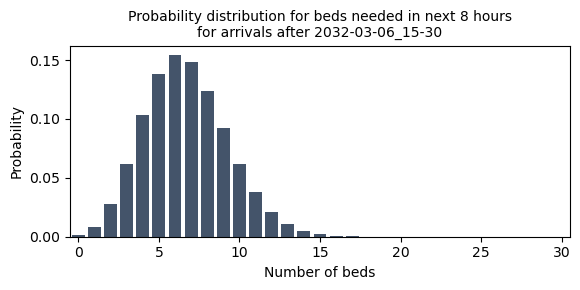

In [187]:
from joblib import load
prediction_window = 480
MODEL__ED_YETTOARRIVE__NAME = 'ed_yet_to_arrive_all_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / MODEL__ED_YETTOARRIVE__NAME 
full_path = full_path.with_suffix('.joblib')

# only medical patients
prediction_context = {
    'default': {
        'prediction_time': prediction_time_ 
    }
}

model = load(full_path)
prob_dist_yta = model.predict(prediction_context, x1, y1, x2, y2)

if full_output:

    title_ = f'Probability distribution for beds needed in next {int(prediction_window/60)} hours\nfor arrivals after {snapshot_datetime}'
    prob_dist_plot(prob_dist_yta['default'],figsize=figsize_global, title_=title_, directory_path=full_file_path, include_titles = True, truncate_at_beds=30, 
                   bar_colour = spec_colour_dict['single']['all'], file_name = f'Full Figure j')
    
else: 

    title_ = 'Figure j all' 
    prob_dist_plot(prob_dist_yta['default'],figsize=figsize_global, title_=title_, directory_path=pipeline_file_path, text_size = 20,  truncate_at_beds=30, 
                   bar_colour = spec_colour_dict['single']['all'], file_name = f'Figure j')

    


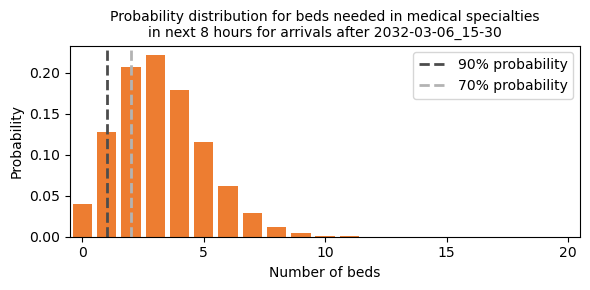

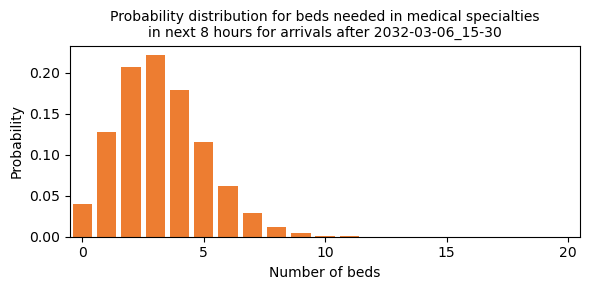

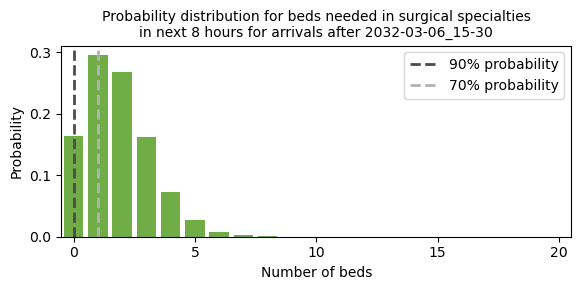

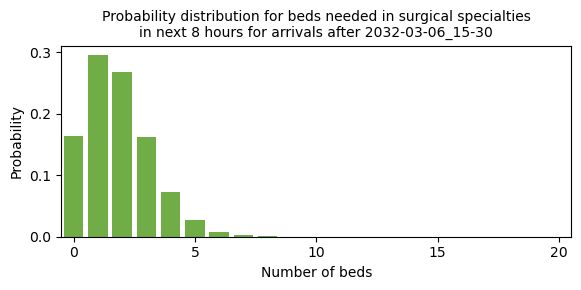

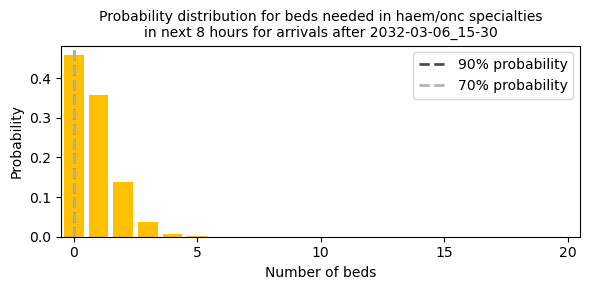

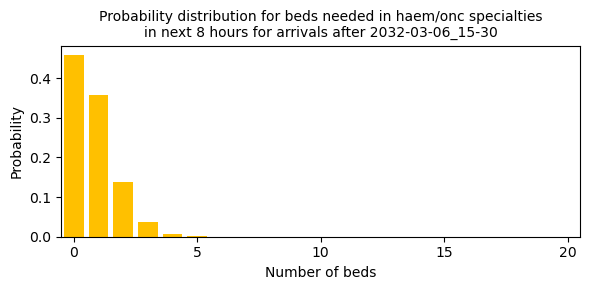

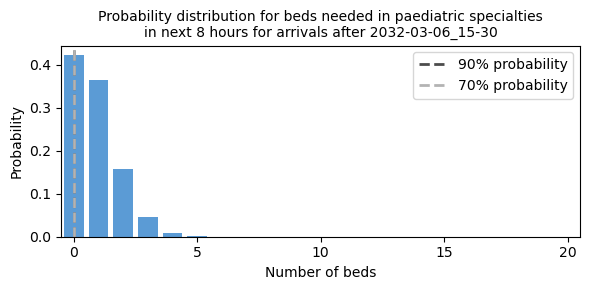

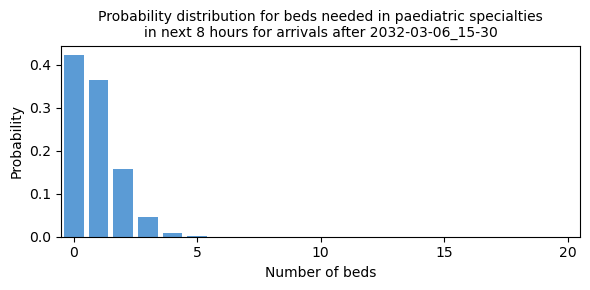

In [188]:
from ed_admissions_realtime_preds import index_of_sum
from viz.prob_dist_plot import prob_dist_plot
cvisits_cut_points = [0.9, 0.7]


MODEL__ED_YETTOARRIVE__NAME = 'ed_yet_to_arrive_by_spec_' + str(int(prediction_window/60)) + '_hours'
full_path = model_file_path / MODEL__ED_YETTOARRIVE__NAME 
full_path = full_path.with_suffix('.joblib')

model_by_spec = load(full_path)

for spec_ in ['medical', 'surgical', 'haem/onc', 'paediatric']:

    prediction_context = {
        spec_: {
            'prediction_time': prediction_time_ 
        }
    }

    model = load(full_path)
    prob_dist_yta_spec = model.predict(prediction_context, x1, y1, x2, y2)

    plot_lines_at = {}

    for cut_point in cvisits_cut_points: 
        
        plot_lines_at[cut_point] = index_of_sum(prob_dist_yta_spec[spec_]["agg_proba"].values, cut_point)
    
    if full_output:

        title_ = f'Probability distribution for beds needed in {spec_} specialties\nin next {int(prediction_window/60)} hours for arrivals after {snapshot_datetime}'
        # with cvisits lines
        prob_dist_plot(prob_dist_yta_spec[spec_],figsize=figsize_global, title_=title_, directory_path=full_file_path, include_titles = True, truncate_at_beds=20, 
                    bar_colour = spec_colour_dict['single'][spec_], file_name = f'Full Figure j {spec_.replace("/", "_")} with cvisits lines', min_beds_lines = plot_lines_at)
        # without cvisits lines
        prob_dist_plot(prob_dist_yta_spec[spec_],figsize=figsize_global, title_=title_, directory_path=full_file_path, include_titles = True, truncate_at_beds=20, 
            bar_colour = spec_colour_dict['single'][spec_], file_name = f'Full Figure j {spec_.replace("/", "_")}')
        
    else:

        title_ = 'Figure g' 
        # with cvisits lines
        prob_dist_plot(prob_dist_yta_spec[spec_],figsize=figsize_global, title_=title_, directory_path=pipeline_file_path, text_size = 20,  truncate_at_beds=20, 
                       bar_colour = spec_colour_dict['single'][spec_], file_name = f'Figure j {spec_.replace("/", "_")} with cvisits lines', min_beds_lines = plot_lines_at)

        # with cvisits lines
        prob_dist_plot(prob_dist_yta_spec[spec_],figsize=figsize_global, title_=title_, directory_path=pipeline_file_path, text_size = 20,  truncate_at_beds=20, 
                       bar_colour = spec_colour_dict['single'][spec_], file_name = f'Figure j {spec_.replace("/", "_")}')


### Optional net position plot

### Optional arrival rates plot

In [1]:
arrival_rates_15min = model_by_spec.get_weights()['medical'][(15,30)]['lambda_t']

# Initialize an empty array to hold the arrival rates for the 8 one-hour periods
arrival_rates_1hour = np.zeros(8)

# Calculate the arrival rates for each one-hour period
for i in range(9):
    arrival_rates_1hour[i] = np.sum(arrival_rates_15min[i*4:(i+1)*4])

NameError: name 'model_by_spec' is not defined

In [197]:
arrival_rates_1hour

array([0.88439306, 0.81888247, 0.71290944, 0.68015414, 0.63583815,
       0.56840077, 0.3911368 , 0.32369942])

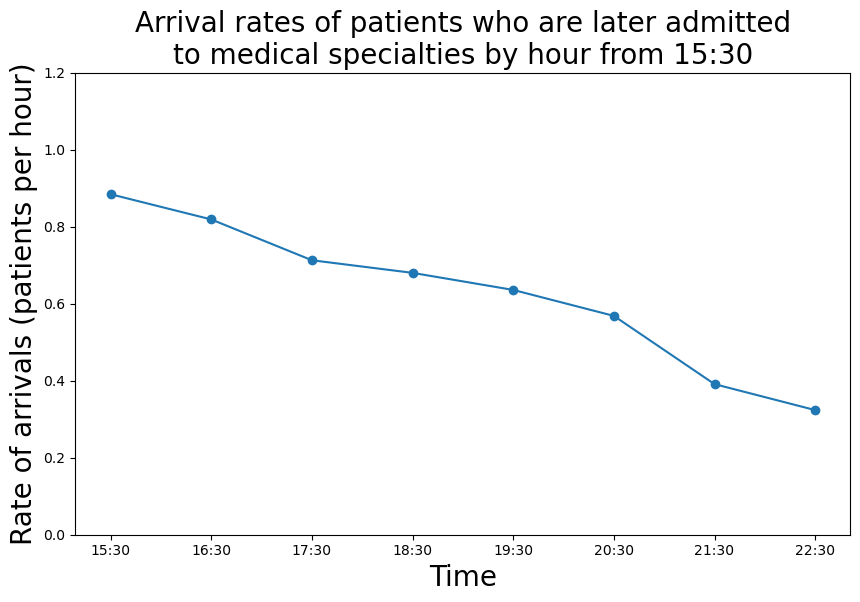

In [217]:
time_labels = ['15:30', '16:30', '17:30', '18:30', '19:30', '20:30', '21:30', '22:30']
# Plot the arrival rates
plt.figure(figsize=(10, 6))
plt.plot(time_labels, arrival_rates_1hour, marker='o')
plt.title('Arrival rates of patients who are later admitted\nto medical specialties by hour from 15:30', fontsize = 20)
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Rate of arrivals (patients per hour)', fontsize = 20)
plt.ylim(bottom=0, top = 1.2)  # Start y-axis from zero

plt.show()

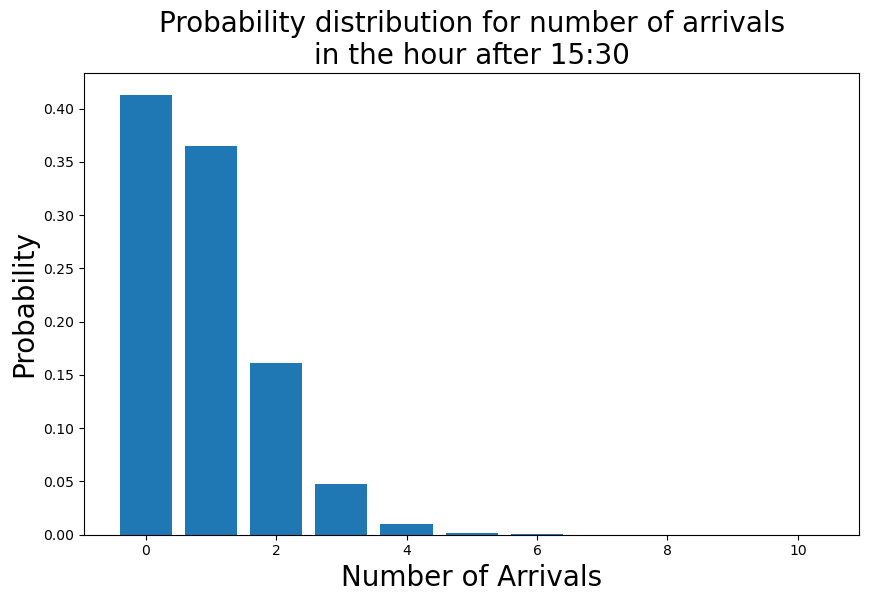

In [215]:
from scipy.stats import poisson

# Select one of the arrival rates for the Poisson distribution
selected_rate = arrival_rates_1hour[0]  # For example, use the first one-hour period's rate

# Generate a range of values for the Poisson distribution
x = np.arange(0, np.max(arrival_rates_1hour) + 10)
poisson_pmf = poisson.pmf(x, selected_rate)

# Plot the Poisson distribution
plt.figure(figsize=(10, 6))
plt.bar(x, poisson_pmf)
plt.title('Probability distribution for number of arrivals\nin the hour after 15:30', fontsize = 20)
plt.xlabel('Number of Arrivals', fontsize = 20)
plt.ylabel('Probability', fontsize = 20)
plt.show()